## Imports

In [2]:
# Imports
# Standard Library
import os
import logging
import warnings
import collections
from typing import TYPE_CHECKING, Callable, Iterable, Literal
import math
# ─────────────────────────────────────────────────────────────
# Scientific Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────────────────────
# PyTorch Core 
import torch
from torch.distributions import Distribution
import torch.nn.functional as F
from torch import nn
from torch.nn import ModuleList
from torch.nn.functional import one_hot
from torch.distributions import Normal

# ─────────────────────────────────────────────────────────────
# Single-cell analysis tools
import anndata
import scanpy as sc
from anndata import AnnData

# ─────────────────────────────────────────────────────────────
# scvi-tools Core
import scvi
from scvi import REGISTRY_KEYS, settings
from scvi.data import AnnDataManager
from scvi.data._constants import ADATA_MINIFY_TYPE
from scvi.data._utils import _get_adata_minify_type
from scvi.data.fields import (
    CategoricalObsField,
    CategoricalJointObsField,
    NumericalObsField,
    NumericalJointObsField,
    LayerField,
)

# ─────────────────────────────────────────────────────────────
# cvi-tools Models & Modules
from scvi.model._utils import _init_library_size
from scvi.model.base import (
    EmbeddingMixin,
    UnsupervisedTrainingMixin,
    ArchesMixin,
    BaseMinifiedModeModelClass,
    RNASeqMixin,
    VAEMixin,
)

from scvi.module._constants import MODULE_KEYS
from scvi.module.base import (
    BaseMinifiedModeModuleClass,
    EmbeddingModuleMixin,
    LossOutput,
    auto_move_data,
)

from scvi.nn import Encoder
from scvi.nn import FCLayers
from scvi.nn._utils import ExpActivation
from scvi.utils import (
    unsupported_if_adata_minified,
    setup_anndata_dsp,
)

# ─────────────────────────────────────────────────────────────
# Type Hints (not executed)
if TYPE_CHECKING:
    from torch.distributions import Distribution
    from anndata import AnnData

# ─────────────────────────────────────────────────────────────
# Helpers
def _identity(x):
    return x

# Logger setup
logger = logging.getLogger(__name__)

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")


/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


## Implementation

In [3]:
class DecoderCCVI(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        n_cell_types: int,
        n_layers: int = 1,
        n_hidden: int = 128,
        n_cat_list: Iterable[int] = None,
        inject_covariates: bool = False,
        use_batch_norm: bool = False,
        use_layer_norm: bool = False,
        scale_activation: Literal["softmax", "softplus"] = "softplus",
        cycle_gene_mask: torch.Tensor | None = None,
        n_fourier: int = 3,
        **kwargs
    ):
        super().__init__()

        if cycle_gene_mask is None:
            cycle_gene_mask = torch.ones(n_output, dtype=torch.bool)
        elif cycle_gene_mask.shape[0] != n_output:
            raise ValueError("`cycle_gene_mask` must match n_output")

        self.register_buffer("cycle_mask", cycle_gene_mask.float())
        self.n_output = n_output
        self.n_fourier = n_fourier

        # --- Fourier weights and offset ---
        self.fourier_W = nn.Parameter(0.01 * torch.randn(2 * n_fourier, n_output))
        self.offset = nn.Parameter(0.01 * torch.randn(1, n_output))

        self.fourier_W.data[:, ~cycle_gene_mask] = 0.0
        self.offset.data[:, ~cycle_gene_mask] = 0.0

        grad_mask = torch.zeros_like(self.fourier_W)
        grad_mask[:, cycle_gene_mask] = 1.0

        def mask_gradient(grad):
            return grad * grad_mask.to(grad.device)
        self.fourier_W.register_hook(mask_gradient)

        # --- Drug response network ---
        self.drug_response_nn = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_output)
        )

        self.b_type = nn.Parameter(0.01 * torch.randn(n_cell_types, n_output))
        self.disp_raw = nn.Parameter(0.01 * torch.randn(n_cell_types, n_output))

        self.px_scale_activation = (
            nn.Softmax(dim=-1) if scale_activation == "softmax" else nn.Softplus()
        )

    def forward(self, z: torch.Tensor, library: torch.Tensor, d: torch.Tensor, t: torch.Tensor):
        assert d.ndim == 2 and d.size(1) == 1
        assert t.ndim == 1

        control_mask = (d.squeeze() == 0)
        device = z.device
        cycle_mask = self.cycle_mask.to(device)

        # --- Cell cycle effect ---
        raw = z[:, 0]
        mean = raw.mean(dim=0, keepdim=True)
        std = raw.std(dim=0, keepdim=True) + 1e-6
        standardized = (raw - mean) / std
        angle = 2 * torch.pi * torch.sigmoid(standardized)
        angle = angle.unsqueeze(1)

        basis_components = []
        for k in range(1, self.n_fourier + 1):
            basis_components.append(torch.cos(k * angle))
            basis_components.append(torch.sin(k * angle))
        fourier_basis = torch.cat(basis_components, dim=1)

        cycle_effect = (fourier_basis @ self.fourier_W) + self.offset
        cycle_effect = cycle_effect * cycle_mask

        # --- Drug effect (NN(d) if d > 0 else 0) ---
        drug_effect = torch.zeros(z.size(0), self.n_output, dtype=z.dtype, device=z.device)
        treated_mask = (d.squeeze() > 0)
        if treated_mask.any():
            d_treated = d[treated_mask]  # [N_treated, 1]
            effect_treated = self.drug_response_nn(d_treated)  # [N_treated, G]
            drug_effect[treated_mask] = effect_treated

        # --- Baseline and dispersion ---
        b_t = self.b_type[t]
        disp_raw = self.disp_raw[t]
        disp = F.softplus(disp_raw)

        eta = b_t + cycle_effect + drug_effect
        px_scale = self.px_scale_activation(eta)
        px_rate = torch.exp(library) * px_scale

        return (
            px_scale,
            disp,
            px_rate,
            None,
            angle,
            drug_effect,
            None,
            self.fourier_W,
            None,
            self.b_type
        )


# ─────────────────────────────────────────────────────────────

class CC_VAE(
# 1. CLASS INHERITANCE
    EmbeddingModuleMixin, BaseMinifiedModeModuleClass):
# 2. ClASS DOCSTRING
    """
    Variational auto-encoder.

    This class implements a variational autoencoder (VAE) for single-cell RNA-seq data.
    It inherits from an embedding mixin (for latent representations) and a base module class
    that supports minified AnnData mode.
    
    Parameters
    ----------
    n_input
        Number of input features.
    n_batch
        Number of batches. If ``0``, no batch correction is performed.
    n_labels
        Number of labels.
    n_hidden
        Number of nodes per hidden layer. Passed into Encoder and DecoderSCVI.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers. Passed into Encoder and DecoderSCVI.
    n_continuous_cov
        Number of continuous covariates.
    n_cats_per_cov
        A list of integers containing the number of categories for each categorical covariate.
    dropout_rate
        Dropout rate, passed into the Encoder.
    dispersion
        Parameter controlling dispersion for the likelihood distribution.
    log_variational
        Whether to apply log1p to input data for numerical stability.
    gene_likelihood
        Likelihood distribution for gene expression (e.g. "zinb", "nb", "poisson").
    latent_distribution
        Distribution for the latent space (e.g. "normal", "ln").
    encode_covariates
        Whether to concatenate covariates to the gene expression before encoding.
    deeply_inject_covariates
        If True and n_layers > 1, covariates are injected at each hidden layer.
    batch_representation
        How to represent batch information ("one-hot" or "embedding").
    use_batch_norm
        Where to use Batch Normalization ("none", "encoder", "decoder", "both").
    use_layer_norm
        Where to use Layer Normalization ("none", "encoder", "decoder", "both").
    use_size_factor_key
        If True, use an AnnData.obs column as the scaling factor for the likelihood.
    use_observed_lib_size
        If True, use the observed library size for scaling.
    library_log_means
        Numpy array with means for log library sizes (if not using observed library size).
    library_log_vars
        Numpy array with variances for log library sizes (if not using observed library size).
    var_activation
        Callable for ensuring positivity of the variance output in the encoder.
    extra_encoder_kwargs
        Extra keyword arguments for the Encoder.
    extra_decoder_kwargs
        Extra keyword arguments for the DecoderSCVI.
    batch_embedding_kwargs
        Keyword arguments for the batch embedding layer (if using embedding representation).
    """

# 3. CONSTRUCTOR
    '''
    - Checks and stores all parameters
    - Handles dispersion type (per gene/cell/batch/label)
    - Initializes encoders: 
            z_encoder for latent variables
        latent_distribution: Literal["normal", "ln"] = "normal",
            # Distribution used for latent variables ("normal" or "logistic normal")
        encode_covariates: bool = False,  # Whether to concatenate covariates with gene expression data
        deeply_inject_covariates: bool = True,  # Whether to inject covariates at deeper layers in the encoder/decoder
        batch_representation: Literal["one-hot", "embedding"] = "one-hot",
            # How to represent batch information (one-hot vector or learned embedding)
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
            # Where to apply Batch Normalization in the network
            l_encoder for library size
    - Initializes decoder based on latent space + covariates
    - Handles categorical and continuous covariates'''
    
    def __init__(
        self,
        n_input: int,   # Number of input features (e.g., number of genes)
        n_batch: int = 0,  # Number of batches; 0 implies no batch correction
        n_labels: int = 0,  # Number of labels (if any)
        n_hidden: int = 128,  # Number of nodes in each hidden layer
        n_latent: int = 10,   # Dimensionality of the latent space
        n_layers: int = 1,    # Number of layers in the encoder/decoder networks
        n_continuous_cov: int = 0,  # Number of continuous covariates
        n_cats_per_cov: list[int] | None = None,  # List with number of categories for each categorical covariate
        dropout_rate: float = 0.1,  # Dropout rate for the neural network layers
        dispersion: Literal["gene", "gene-batch", "gene-label", "gene-cell"] = "gene-label",
            # Dispersion model: how variance is modeled (per gene, per batch, etc.)
        log_variational: bool = True,  # Whether to apply log1p on input data for numerical stability
        gene_likelihood: Literal["zinb", "nb", "poisson"] = "nb",
            # Likelihood model for gene expression (Zero-Inflated Negative Binomial, etc.)
        latent_distribution: Literal["normal", "ln"] = "normal",
            # Distribution used for latent variables ("normal" or "logistic normal")
        encode_covariates: bool = False,  # Whether to concatenate covariates with gene expression data
        deeply_inject_covariates: bool = True,  # Whether to inject covariates at deeper layers in the encoder/decoder
        batch_representation: Literal["one-hot", "embedding"] = "one-hot",
            # How to represent batch information (one-hot vector or learned embedding)
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
            # Where to apply Batch Normalization in the network
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "none",
            # Where to apply Layer Normalization in the network
        use_size_factor_key: bool = False,  # Whether to use size factors from AnnData.obs as scaling factors
        use_observed_lib_size: bool = True,  # Whether to use the observed library size directly for scaling
        library_log_means: np.ndarray | None = None,  # Precomputed means of log library sizes (if not observed)
        library_log_vars: np.ndarray | None = None,   # Precomputed variances of log library sizes (if not observed)
        var_activation: Callable[[torch.Tensor], torch.Tensor] = None,  # Activation for variance output (e.g., torch.exp)
        extra_encoder_kwargs: dict | None = None,  # Additional parameters for the Encoder
        extra_decoder_kwargs: dict | None = None,  # Additional parameters for the DecoderSCVI
        batch_embedding_kwargs: dict | None = None,  # Additional parameters for batch embedding layer (if used)
        cycle_gene_mask: torch.Tensor | None = None,
    ):

        super().__init__()  # Initialize parent classes (EmbeddingModuleMixin and BaseMinifiedModeModuleClass)

        # Store various model parameters as attributes
        self.dispersion = dispersion
        self.n_latent = n_latent
        self.log_variational = log_variational
        self.gene_likelihood = gene_likelihood
        self.n_batch = n_batch
        self.n_labels = n_labels
        self.latent_distribution = latent_distribution
        self.encode_covariates = encode_covariates
        self.use_size_factor_key = use_size_factor_key
        # If size factor key is used, then use_observed_lib_size is True; otherwise, use the provided flag
        self.use_observed_lib_size = use_size_factor_key or use_observed_lib_size

        # If not using observed library size, then library_log_means and library_log_vars must be provided
        if not self.use_observed_lib_size:
            if library_log_means is None or library_log_vars is None:
                raise ValueError(
                    "If not using observed_lib_size, must provide library_log_means and library_log_vars."
                )
            # Register these as buffers (non-parameter tensors that move with the model)
            self.register_buffer("library_log_means", torch.from_numpy(library_log_means).float())
            self.register_buffer("library_log_vars", torch.from_numpy(library_log_vars).float())

        # Setup batch representation; if embedding is chosen, initialize an embedding layer
        self.batch_representation = batch_representation
        if self.batch_representation == "embedding":
            # Initialize embedding for batches using a key from REGISTRY_KEYS and extra kwargs if provided
            self.init_embedding(REGISTRY_KEYS.BATCH_KEY, n_batch, **(batch_embedding_kwargs or {}))
            # Get the embedding dimension from the initialized embedding layer
            batch_dim = self.get_embedding(REGISTRY_KEYS.BATCH_KEY).embedding_dim
        elif self.batch_representation != "one-hot":
            raise ValueError("`batch_representation` must be one of 'one-hot', 'embedding'.")

        # Determine where to apply normalization in the encoder and decoder
        use_batch_norm_encoder = use_batch_norm == "encoder" or use_batch_norm == "both"
        use_batch_norm_decoder = use_batch_norm == "decoder" or use_batch_norm == "both"
        use_layer_norm_encoder = use_layer_norm == "encoder" or use_layer_norm == "both"
        use_layer_norm_decoder = use_layer_norm == "decoder" or use_layer_norm == "both"

        # Calculate the input dimension for the encoder. Start with gene counts and add covariates if encoding them.
        n_input_encoder = n_input + n_continuous_cov * encode_covariates
        if self.batch_representation == "embedding":
            n_input_encoder += batch_dim * encode_covariates  # Add batch embedding dimension if applicable
            cat_list = list([] if n_cats_per_cov is None else n_cats_per_cov)
        else:
            # For one-hot, add n_batch as a categorical variable
            cat_list = [n_batch] + list([] if n_cats_per_cov is None else n_cats_per_cov)

        # Only include categorical covariates if requested
        encoder_cat_list = cat_list if encode_covariates else None
        _extra_encoder_kwargs = extra_encoder_kwargs or {}
        # Initialize the encoder for the latent variable "z"
        self.z_encoder = Encoder(
            n_input_encoder,
            n_latent,
            n_cat_list=encoder_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,  # Return a distribution rather than a fixed tensor
            **_extra_encoder_kwargs,
        )

        # Calculate input dimension for the decoder: latent dimension plus continuous covariates
        n_input_decoder = n_latent
        if self.batch_representation == "embedding":
            n_input_decoder += batch_dim  # Add embedding dimension for batch representation

        _extra_decoder_kwargs = extra_decoder_kwargs or {}
        # Initialize the decoder module that maps latent space back to the original input space
        self.decoder = DecoderCCVI(
            n_input=n_input_decoder,
            n_output=n_input,
            n_cell_types=n_labels,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_decoder,
            use_layer_norm=use_layer_norm_decoder,
            scale_activation="softplus" if use_size_factor_key else "softmax",
            cycle_gene_mask=cycle_gene_mask, # Or set a specific float if you want to control bump width
            **_extra_decoder_kwargs,
        )
# 4. Prepare tensors for inference 
    def _get_inference_input(
        self,
        tensors: dict[str, torch.Tensor | None],
        full_forward_pass: bool = False,
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the inference process."""
        # Decide which data loader to use based on full_forward_pass flag and the minified data type
        if full_forward_pass or self.minified_data_type is None:
            loader = "full_data"
        elif self.minified_data_type in [
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR,
            ADATA_MINIFY_TYPE.LATENT_POSTERIOR_WITH_COUNTS,
        ]:
            loader = "minified_data"
        else:
            raise NotImplementedError(f"Unknown minified-data type: {self.minified_data_type}")

        # For full data, return the standard tensors used in the model
        if loader == "full_data":
            return {
                MODULE_KEYS.X_KEY: tensors[REGISTRY_KEYS.X_KEY],
                MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
                MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
                MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            }
        else:
            # For minified data, use cached latent parameters
            return {
                MODULE_KEYS.QZM_KEY: tensors[REGISTRY_KEYS.LATENT_QZM_KEY],
                MODULE_KEYS.QZV_KEY: tensors[REGISTRY_KEYS.LATENT_QZV_KEY],
                REGISTRY_KEYS.OBSERVED_LIB_SIZE: tensors[REGISTRY_KEYS.OBSERVED_LIB_SIZE],
            }

# 5. Prepare tensors for generative model  
    def _get_generative_input(
        self,
        tensors: dict[str, torch.Tensor],
        inference_outputs: dict[str, torch.Tensor | Distribution | None],
    ) -> dict[str, torch.Tensor | None]:
        """Get input tensors for the generative process."""
        # Retrieve and transform size factor if provided
        size_factor = tensors.get(REGISTRY_KEYS.SIZE_FACTOR_KEY, None)
        if size_factor is not None:
            size_factor = torch.log(size_factor)

        # Return a dictionary mapping module keys to the appropriate tensors/distributions
        return {
            MODULE_KEYS.Z_KEY: inference_outputs[MODULE_KEYS.Z_KEY],
            MODULE_KEYS.LIBRARY_KEY: inference_outputs[MODULE_KEYS.LIBRARY_KEY],
            MODULE_KEYS.BATCH_INDEX_KEY: tensors[REGISTRY_KEYS.BATCH_KEY],
            MODULE_KEYS.Y_KEY: tensors[REGISTRY_KEYS.LABELS_KEY],
            MODULE_KEYS.CONT_COVS_KEY: tensors.get(REGISTRY_KEYS.CONT_COVS_KEY, None),
            MODULE_KEYS.CAT_COVS_KEY: tensors.get(REGISTRY_KEYS.CAT_COVS_KEY, None),
            MODULE_KEYS.SIZE_FACTOR_KEY: size_factor,
        }

# 6. For each cell, computes the mean and variance of the log library size for the corresponding batch.
    def _compute_local_library_params(
        self,
        batch_index: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes local library parameters.

        For each cell, computes the mean and variance of the log library size
        for the corresponding batch.
        """
        from torch.nn.functional import linear

        n_batch = self.library_log_means.shape[1]  # Number of batches from the library means buffer
        # Compute local means using one-hot encoding for the batch index and linear transformation
        local_library_log_means = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_means
        )
        # Compute local variances similarly
        local_library_log_vars = linear(
            one_hot(batch_index.squeeze(-1), n_batch).float(), self.library_log_vars
        )

        return local_library_log_means, local_library_log_vars

    @auto_move_data  # Automatically move inputs/outputs to the correct device (CPU/GPU)

# 7. Encodes input data into latent variables:
    def _regular_inference(
        self,
        x: torch.Tensor,                 # Input gene expression data
        batch_index: torch.Tensor,       # Batch indices for each cell
        cont_covs: torch.Tensor | None = None,  # Continuous covariates (if any)
        cat_covs: torch.Tensor | None = None,   # Categorical covariates (if any)
        n_samples: int = 1,                # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | Distribution | None]:
        """Run the regular inference process."""
        x_ = x  # Make a copy of the input
        # If using observed library size, compute it as the log sum of gene counts
        if self.use_observed_lib_size:
            library = torch.log(x.sum(1)).unsqueeze(1)
        # Apply logarithmic transformation if specified
        if self.log_variational:
            x_ = torch.log1p(x_)

        # Concatenate continuous covariates if they are to be encoded
        if cont_covs is not None and self.encode_covariates:
            encoder_input = torch.cat((x_, cont_covs), dim=-1)
        else:
            encoder_input = x_
        # Split categorical covariates along the feature dimension if available
        if cat_covs is not None and self.encode_covariates:
            categorical_input = torch.split(cat_covs, 1, dim=1)
        else:
            categorical_input = ()

        # If using an embedding for batch information, compute and concatenate it to the encoder input
        if self.batch_representation == "embedding" and self.encode_covariates:
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            encoder_input = torch.cat([encoder_input, batch_rep], dim=-1)
            qz, z = self.z_encoder(encoder_input, *categorical_input)
        else:
            # Otherwise, pass batch_index directly to the encoder
            qz, z = self.z_encoder(encoder_input, batch_index, *categorical_input)

        ql = None
        # If not using observed library size, encode library size using l_encoder
        if not self.use_observed_lib_size:
            if self.batch_representation == "embedding":
                ql, library_encoded = self.l_encoder(encoder_input, *categorical_input)
            else:
                ql, library_encoded = self.l_encoder(encoder_input, batch_index, *categorical_input)
            library = library_encoded

        # If more than one Monte Carlo sample is requested, sample from the distributions
        if n_samples > 1:
            untran_z = qz.sample((n_samples,))
            z = self.z_encoder.z_transformation(untran_z)
            if self.use_observed_lib_size:
                library = library.unsqueeze(0).expand(
                    (n_samples, library.size(0), library.size(1))
                )
            else:
                library = ql.sample((n_samples,))

        # Return the inference outputs as a dictionary
        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: ql,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data
    def _cached_inference(
        self,
        qzm: torch.Tensor,          # Cached latent mean values
        qzv: torch.Tensor,          # Cached latent variance values
        observed_lib_size: torch.Tensor,  # Observed library size values
        n_samples: int = 1,         # Number of samples for Monte Carlo approximation
    ) -> dict[str, torch.Tensor | None]:
        """Run the cached inference process."""

        # Reconstruct the latent distribution using the cached parameters
        qz = Normal(qzm, qzv.sqrt())
        # Sample from the latent distribution; using sample() (non-reparameterized)
        untran_z = qz.sample() if n_samples == 1 else qz.sample((n_samples,))
        # Transform the sampled latent variables if necessary
        z = self.z_encoder.z_transformation(untran_z)
        # Compute the library by taking log of the observed library size
        library = torch.log(observed_lib_size)
        if n_samples > 1:
            library = library.unsqueeze(0).expand((n_samples, library.size(0), library.size(1)))

        return {
            MODULE_KEYS.Z_KEY: z,
            MODULE_KEYS.QZ_KEY: qz,
            MODULE_KEYS.QL_KEY: None,
            MODULE_KEYS.LIBRARY_KEY: library,
        }

    @auto_move_data

# 8. Decodes latent z back to gene expression
    def generative(
        self,
        z: torch.Tensor,
        library: torch.Tensor,
        batch_index: torch.Tensor,
        cont_covs: torch.Tensor | None = None,
        cat_covs: torch.Tensor | None = None,
        size_factor: torch.Tensor | None = None,
        y: torch.Tensor | None = None,
        transform_batch: torch.Tensor | None = None,
    ) -> dict[str, Distribution | None]:
        from scvi.distributions import NegativeBinomial, Normal, Poisson, ZeroInflatedNegativeBinomial
    
        # Extract d and t
        d = cont_covs[:, 0:1] if cont_covs is not None else None
        t = y.squeeze(-1)
    
        # Build decoder input
        decoder_input = z
        if self.batch_representation == "embedding":
            batch_rep = self.compute_embedding(REGISTRY_KEYS.BATCH_KEY, batch_index)
            decoder_input = torch.cat([z, batch_rep], dim=-1)
    
        if transform_batch is not None:
            batch_index = torch.ones_like(batch_index) * transform_batch
    
        if not self.use_size_factor_key:
            size_factor = library
    
        # Run decoder
        px_scale, disp, px_rate, _, angle, drug_effect, _, W_fourier, _, b_type = self.decoder(
            decoder_input, size_factor, d, t
        )
        px_r = torch.exp(disp)
    
        # Gene likelihood
        if self.gene_likelihood == "zinb":
            px = ZeroInflatedNegativeBinomial(mu=px_rate, theta=px_r, zi_logits=None, scale=px_scale)
        elif self.gene_likelihood == "nb":
            px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)
        elif self.gene_likelihood == "poisson":
            px = Poisson(rate=px_rate, scale=px_scale)
        elif self.gene_likelihood == "normal":
            px = Normal(px_rate, px_r, normal_mu=px_scale)
    
        if self.use_observed_lib_size:
            pl = None
        else:
            local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
            pl = Normal(local_library_log_means, local_library_log_vars.sqrt())
    
        pz = Normal(torch.zeros_like(z), torch.ones_like(z))
    
        return {
            MODULE_KEYS.PX_KEY: px,
            MODULE_KEYS.PL_KEY: pl,
            MODULE_KEYS.PZ_KEY: pz,
            "angle": angle
        }

    @unsupported_if_adata_minified  # Mark this method as unsupported if AnnData is in minified mode


    def loss(
        self,
        tensors: dict[str, torch.Tensor],
        inference_outputs: dict[str, torch.Tensor | Distribution | None],
        generative_outputs: dict[str, Distribution | torch.Tensor | None],
        kl_weight: torch.Tensor | float = 1.0,
    ) -> LossOutput:
        from torch.distributions import kl_divergence
    
        x = tensors[REGISTRY_KEYS.X_KEY]
    
        kl_divergence_z = kl_divergence(
            inference_outputs[MODULE_KEYS.QZ_KEY], generative_outputs[MODULE_KEYS.PZ_KEY]
        ).sum(dim=-1)
    
        if not self.use_observed_lib_size:
            kl_divergence_l = kl_divergence(
                inference_outputs[MODULE_KEYS.QL_KEY], generative_outputs[MODULE_KEYS.PL_KEY]
            ).sum(dim=1)
        else:
            kl_divergence_l = torch.zeros_like(kl_divergence_z)
    
        reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
        kl_local_for_warmup = kl_divergence_z
        kl_local_no_warmup = kl_divergence_l
        weighted_kl_local = 0.1*kl_weight * kl_local_for_warmup + kl_local_no_warmup
    
        # ---- Total Loss ----
        loss = torch.mean(reconst_loss + weighted_kl_local)
    
        return LossOutput(
            loss=loss,
            reconstruction_loss=reconst_loss,
            kl_local={
                MODULE_KEYS.KL_L_KEY: kl_divergence_l,
                MODULE_KEYS.KL_Z_KEY: kl_divergence_z,
            },
            extra_metrics={
                "z": inference_outputs["z"],
                "batch": tensors[REGISTRY_KEYS.BATCH_KEY],
                "labels": tensors[REGISTRY_KEYS.LABELS_KEY],
            },
        )
    
            

    @torch.inference_mode()

# 10. Samples gene expression from the posterior predictive distribution
    def sample(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for sampling
        n_samples: int = 1,                  # Number of Monte Carlo samples to draw per observation
        max_poisson_rate: float = 1e8,       # Maximum value to clip Poisson rate to avoid numerical issues
    ) -> torch.Tensor:
        r"""Generate predictive samples from the posterior predictive distribution.

        The posterior predictive distribution is denoted as :math:`p(\hat{x} \mid x)`, where
        :math:`x` is the input data and :math:`\hat{x}` is the sampled data.

        We sample from this distribution by first sampling ``n_samples`` times from the posterior
        distribution :math:`q(z \mid x)` for a given observation, and then sampling from the
        likelihood :math:`p(\hat{x} \mid z)` for each of these.
        """
        from scvi.distributions import Poisson

        inference_kwargs = {"n_samples": n_samples}
        # Run a forward pass to get generative outputs (without computing loss)
        _, generative_outputs = self.forward(
            tensors, inference_kwargs=inference_kwargs, compute_loss=False
        )

        dist = generative_outputs[MODULE_KEYS.PX_KEY]
        if self.gene_likelihood == "poisson":
            # Handle potential issues on MPS devices by clamping the Poisson rate
            dist = (
                Poisson(torch.clamp(dist.rate.to("cpu"), max=max_poisson_rate))
                if self.device.type == "mps"
                else Poisson(torch.clamp(dist.rate, max=max_poisson_rate))
            )

        # Draw samples from the likelihood distribution; shape depends on n_samples
        samples = dist.sample()
        # If multiple samples were drawn, permute dimensions so that output is (n_obs, n_vars, n_samples)
        samples = torch.permute(samples, (1, 2, 0)) if n_samples > 1 else samples

        return samples.cpu()  # Return samples on CPU

    @torch.inference_mode()
    @auto_move_data

# Estimates marginal log-likelihood with Monte Carlo sampling

    def marginal_ll(
        self,
        tensors: dict[str, torch.Tensor],  # Input tensors for marginal likelihood computation
        n_mc_samples: int,  # Total number of Monte Carlo samples for estimation
        return_mean: bool = False,  # Whether to return the mean marginal likelihood over cells
        n_mc_samples_per_pass: int = 1,  # Number of samples per computation pass (to reduce memory usage)
    ):
        """Compute the marginal log-likelihood of the data under the model."""
        from torch import logsumexp
        from torch.distributions import Normal

        batch_index = tensors[REGISTRY_KEYS.BATCH_KEY]

        to_sum = []  # List to accumulate log probabilities over multiple passes
        if n_mc_samples_per_pass > n_mc_samples:
            warnings.warn(
                "Number of chunks is larger than the total number of samples, setting it to the "
                "number of samples",
                RuntimeWarning,
                stacklevel=settings.warnings_stacklevel,
            )
            n_mc_samples_per_pass = n_mc_samples
        n_passes = int(np.ceil(n_mc_samples / n_mc_samples_per_pass))
        for _ in range(n_passes):
            # For each pass, run a forward pass to get inference outputs and loss components
            inference_outputs, _, losses = self.forward(
                tensors,
                inference_kwargs={"n_samples": n_mc_samples_per_pass},
                get_inference_input_kwargs={"full_forward_pass": True},
            )
            qz = inference_outputs[MODULE_KEYS.QZ_KEY]
            ql = inference_outputs[MODULE_KEYS.QL_KEY]
            z = inference_outputs[MODULE_KEYS.Z_KEY]
            library = inference_outputs[MODULE_KEYS.LIBRARY_KEY]

            # Get the reconstruction loss from the losses output
            reconst_loss = losses.dict_sum(losses.reconstruction_loss)

            # Compute log probabilities for the latent variable and reconstruction
            p_z = (
                Normal(torch.zeros_like(qz.loc), torch.ones_like(qz.scale)).log_prob(z).sum(dim=-1)
            )
            p_x_zl = -reconst_loss
            q_z_x = qz.log_prob(z).sum(dim=-1)
            log_prob_sum = p_z + p_x_zl - q_z_x

            if not self.use_observed_lib_size:
                # Compute additional log probabilities for library size if not observed
                local_library_log_means, local_library_log_vars = self._compute_local_library_params(batch_index)
                p_l = (
                    Normal(local_library_log_means, local_library_log_vars.sqrt())
                    .log_prob(library)
                    .sum(dim=-1)
                )
                q_l_x = ql.log_prob(library).sum(dim=-1)
                log_prob_sum += p_l - q_l_x
            if n_mc_samples_per_pass == 1:
                log_prob_sum = log_prob_sum.unsqueeze(0)

            to_sum.append(log_prob_sum)
        # Concatenate all passes and compute log-sum-exp for a Monte Carlo estimate
        to_sum = torch.cat(to_sum, dim=0)
        batch_log_lkl = logsumexp(to_sum, dim=0) - np.log(n_mc_samples)
        if return_mean:
            batch_log_lkl = torch.mean(batch_log_lkl).item()
        else:
            batch_log_lkl = batch_log_lkl.cpu()
        return batch_log_lkl
      
class CCVI(EmbeddingMixin,        # Adds methods for getting latent representations
    RNASeqMixin,                  # Adds single-cell RNA-seq-specific logic
    VAEMixin,                     # Adds methods for working with a VAE model
    ArchesMixin,                  # Adds functionality for transfer learning (ARCHES)
    UnsupervisedTrainingMixin,    # Adds methods for unsupervised training
    BaseMinifiedModeModelClass):
    
    _module_cls = CC_VAE
    _LATENT_QZM_KEY = "ccvi_latent_qzm"  # Key for the latent mean in AnnData
    _LATENT_QZV_KEY = "ccvi_latent_qzv"  # Key for the latent variance in AnnData


# 4. CONSTRUCTOR
    def __init__(
        self,
        adata: AnnData | None = None,  # Input data; can be None (if adata is not provided, the model will delay initialization until train is called).
        n_hidden: int = 128,           # Hidden units per layer
        n_latent: int = 10,            # Dimensionality of latent space
        n_layers: int = 1,             # Number of layers in encoder/decoder neural networks
        dropout_rate: float = 0.1,     # Dropout rate
        dispersion: Literal[...] = "gene-label",         # Type of dispersion parameter
        gene_likelihood: Literal[...] = "nb",    # Distribution to model gene expression
        latent_distribution: Literal[...] = "normal",  # Latent distribution type
        cycle_gene_mask: torch.Tensor | None = None,
        **kwargs,                      # Any other parameters passed to the VAE
    ):
        super().__init__(adata)  # Call the constructor of the parent mixin/base classes

        # Store inputs in a dictionary
        self._module_kwargs = {
            "n_hidden": n_hidden,
            "n_latent": n_latent,
            "n_layers": n_layers,
            "dropout_rate": dropout_rate,
            "dispersion": dispersion,
            "gene_likelihood": gene_likelihood,
            "latent_distribution": latent_distribution,
            "cycle_gene_mask": cycle_gene_mask,
            **kwargs,
        }

        # Create a summary string
        self._model_summary_string = (
            "CCVI drug model with the following parameters: \n"
            f"n_hidden: {n_hidden}, n_latent: {n_latent}, n_layers: {n_layers}, "
            f"dropout_rate: {dropout_rate}, dispersion: {dispersion}, "
            f"gene_likelihood: {gene_likelihood}, latent_distribution: {latent_distribution}."
        )

        # If lazy initialization is enabled (adata is not provided), postpone model creation until training
        if self._module_init_on_train:
            self.module = None
            warnings.warn(
                "Model was initialized without `adata`. The module will be initialized when "
                "calling `train`. This behavior is experimental and may change in the future.",
                UserWarning,
                stacklevel=settings.warnings_stacklevel,
            )
        else:
            # Create a list with the number of categories per categorical variable
            n_cats_per_cov = (
                self.adata_manager.get_state_registry(REGISTRY_KEYS.CAT_COVS_KEY).n_cats_per_key
                if REGISTRY_KEYS.CAT_COVS_KEY in self.adata_manager.data_registry
                else None
            )

            # Get number of batches
            n_batch = self.summary_stats.n_batch

            # Determine if size factor is provided in the data
            use_size_factor_key = REGISTRY_KEYS.SIZE_FACTOR_KEY in self.adata_manager.data_registry

            # Initialize library size params if needed
            library_log_means, library_log_vars = None, None
            if (
                not use_size_factor_key
                and self.minified_data_type != ADATA_MINIFY_TYPE.LATENT_POSTERIOR
            ):
                library_log_means, library_log_vars = _init_library_size(
                    self.adata_manager, n_batch
                )

            # Instantiate the actual VAE model
            self.module = self._module_cls(
                n_input=self.summary_stats.n_vars,  # Number of genes
                n_batch=n_batch,
                n_labels=self.summary_stats.n_labels,
                n_continuous_cov=self.summary_stats.get("n_extra_continuous_covs", 0),
                n_cats_per_cov=n_cats_per_cov,
                n_hidden=n_hidden,
                n_latent=n_latent,
                n_layers=n_layers,
                dropout_rate=dropout_rate,
                dispersion=dispersion,
                gene_likelihood=gene_likelihood,
                latent_distribution=latent_distribution,
                use_size_factor_key=use_size_factor_key,
                library_log_means=library_log_means,
                library_log_vars=library_log_vars,
                cycle_gene_mask=cycle_gene_mask,
                **kwargs,
            )

            # Set minified type to the model (used for memory optimization)
            self.module.minified_data_type = self.minified_data_type

        # Save init parameters for reproducibility
        self.init_params_ = self._get_init_params(locals())

# 5. Define setup_anndata for preproccessing AnnData

    @classmethod
    @setup_anndata_dsp.dedent  # Automatically formats docstring from template
    def setup_anndata(
        cls,
        adata: AnnData,
        layer: str | None = None,  # Which layer of AnnData.X to use
        batch_key: str | None = None,  # Batch annotation column in adata.obs
        labels_key: str | None = None,  # Label annotation column
        size_factor_key: str | None = None,  # Precomputed size factor
        categorical_covariate_keys: list[str] | None = None,  # Categorical covariates
        continuous_covariate_keys: list[str] | None = None,   # Continuous covariates
        **kwargs,
    ):
        """%(summary)s.

        Parameters
        ----------
        %(param_adata)s
        %(param_layer)s
        %(param_batch_key)s
        %(param_labels_key)s
        %(param_size_factor_key)s
        %(param_cat_cov_keys)s
        %(param_cont_cov_keys)s
        """

        # Get arguments as a dictionary
        setup_method_args = cls._get_setup_method_args(**locals())

        # Define how to extract relevant fields from AnnData
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, layer, is_count_data=True),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, labels_key),
            NumericalObsField(REGISTRY_KEYS.SIZE_FACTOR_KEY, size_factor_key, required=False),
            CategoricalJointObsField(REGISTRY_KEYS.CAT_COVS_KEY, categorical_covariate_keys),
            NumericalJointObsField(REGISTRY_KEYS.CONT_COVS_KEY, continuous_covariate_keys),
        ]

        # If this is a "minified" AnnData, add extra required fields
        adata_minify_type = _get_adata_minify_type(adata)
        if adata_minify_type is not None:
            anndata_fields += cls._get_fields_for_adata_minification(adata_minify_type)

        # Create a manager to track and validate all fields
        adata_manager = AnnDataManager(fields=anndata_fields, setup_method_args=setup_method_args)

        # Register fields into the manager
        adata_manager.register_fields(adata, **kwargs)

        # Register the manager for this class (global to model)
        cls.register_manager(adata_manager)


## Load Data

In [4]:
adata = sc.read_h5ad("cluster_files/adata_Dapagliflozin_balanced.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 17192 × 23096
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc', 'n_genes'
    var: 'n_cells'
    layers: 'counts'


In [5]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0,0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print("Sorted Drug concentrations",adata.obs["drugconc_ordered"].unique())

[0.   0.05 0.5  5.  ]
Sorted Drug concentrations [0.00, 0.05, 0.50, 5.00]
Categories (4, float64): [0.00 < 0.05 < 0.50 < 5.00]


## Load Model

In [7]:
model = CCVI.load("ccvi_model_dapagliflozin_drug",adata = adata)
print(model)

INFO     File ccvi_model_dapagliflozin_drug/model.pt already downloaded         
CCVI drug model with the following parameters: 
n_hidden: 128, n_latent: 4, n_layers: 1, dropout_rate: 0.1, dispersion: 
gene-label, gene_likelihood: nb, latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False



## Metrics

In [8]:
# Convert to numpy arrays
recon_train = np.array(model.history["reconstruction_loss_train"])
recon_val = np.array(model.history["reconstruction_loss_validation"])
kl_local_train = np.array(model.history["kl_local_train"])
kl_local_val = np.array(model.history["kl_local_validation"])
kl_global_train = np.array(model.history["kl_global_train"])
kl_global_val = np.array(model.history["kl_global_validation"])
elbo_train = np.array(model.history["elbo_train"])
elbo_val = np.array(model.history["elbo_validation"])
cls_loss_train = np.array(model.history["classification_loss_train"])
cls_loss_val = np.array(model.history["classification_loss_validation"])

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# 1. Reconstruction Error
axs[0].plot(recon_train, label="Train")
axs[0].plot(recon_val, label="Validation", linestyle="--")
axs[0].set_title("Reconstruction Error")
axs[0].legend()

# 2. KL Local
axs[1].plot(kl_local_train, label="Train")
axs[1].plot(kl_local_val, label="Validation", linestyle="--")
axs[1].set_title("KL Divergence (Local)")
axs[1].legend()

# 3. KL Global
axs[2].plot(kl_global_train, label="Train")
axs[2].plot(kl_global_val, label="Validation", linestyle="--")
axs[2].set_title("KL Divergence (Global)")
axs[2].legend()

# 4. ELBO
axs[3].plot(elbo_train, label="Train")
axs[3].plot(elbo_val, label="Validation", linestyle="--")
axs[3].set_title("ELBO")
axs[3].legend()

# 5. Classification Loss
axs[4].plot(cls_loss_train, label="Train")
axs[4].plot(cls_loss_val, label="Validation", linestyle="--")
axs[4].set_title("Classification Loss")
axs[4].legend()

# Final layout
axs[4].set_xlabel("Epoch")
plt.tight_layout()
plt.show()


KeyError: 'classification_loss_train'

In [7]:
# Subset AnnData
adata_train = adata[model.train_indices].copy()
adata_val = adata[model.validation_indices].copy()
adata_test = adata[model.test_indices].copy()

recon_train = model.get_reconstruction_error(adata_train)
recon_val = model.get_reconstruction_error(adata_val)
recon_test = model.get_reconstruction_error(adata_test)

# Print results
print("Reconstruction Error (Train):", recon_train)
print("Reconstruction Error (Val):", recon_val)
print("Reconstruction Error (Test):", recon_test)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.     
INFO     AnnData object appears to be a copy. Attempting to transfer setup.     
INFO     AnnData object appears to be a copy. Attempting to transfer setup.     
Reconstruction Error (Train): {'reconstruction_loss': tensor(4471.9702)}
Reconstruction Error (Val): {'reconstruction_loss': tensor(4474.7632)}
Reconstruction Error (Test): {'reconstruction_loss': tensor(4522.3652)}


## Latent Space

In [8]:
CCVI_LATENT_KEY = "latent_space"

latent = model.get_latent_representation()
adata.obsm[CCVI_LATENT_KEY] = latent
latent.shape

(17192, 4)

### Extract Latent Variables

In [9]:
# Step 1: Extract latent space and drug concentrations
z = torch.tensor(latent, dtype=torch.float32).to(model.device)
d = torch.tensor(adata.obs["drugconc"].values.reshape(-1, 1), dtype=torch.float32).to(model.device)

# Step 2: Split z into interpretable components
z_cycle = z[:, 0:1]
z_identity = z[:, 1:2]

# Step 3: Predict response (only for treated cells)
with torch.no_grad():
    control_mask = (d.squeeze() == 0)
    r = torch.zeros(z.size(0), 1, dtype=torch.float32, device=model.device)

    if (~control_mask).any():
        drug_input = torch.cat([z_cycle[~control_mask], z_identity[~control_mask]], dim=1)
        r_treated = torch.nn.functional.softplus(
            model.module.decoder.drug_response_decoder(drug_input, cont=d[~control_mask])
        )
        r[~control_mask] = r_treated

    # Step 4: Compute cycle angle
    mean = z_cycle.mean(dim=0, keepdim=True)
    std = z_cycle.std(dim=0, keepdim=True) + 1e-6
    standardized = (z_cycle - mean) / std
    angle = 2 * torch.pi * torch.sigmoid(standardized)  # shape [N, 1]

# Step 5: Save results
adata.obs["angle"] = angle.cpu().numpy().squeeze()
adata.obs["response"] = r.cpu().numpy().squeeze()

In [10]:
with torch.no_grad():
    z = model.get_latent_representation()
    d = torch.tensor(adata.obs["drugconc"].values.reshape(-1, 1), dtype=torch.float32)
    t = torch.tensor(adata.obs["cell_name"].cat.codes.values, dtype=torch.long)
    lib = torch.log(torch.tensor(adata.X.sum(1).A1 if hasattr(adata.X.sum(1), 'A1') else adata.X.sum(1), dtype=torch.float32)).reshape(-1, 1)

    decoder_input = torch.tensor(z, dtype=torch.float32)
    px_scale, disp, px_rate, z_baseline_logits, z_baseline_probs, *_ = model.module.decoder(
        decoder_input, lib, d, t
    )

# Extract and save
adata.obs["prob_celltype_0"] = z_baseline_probs[:, 0].cpu().numpy()


### UMAP of Latent Space 

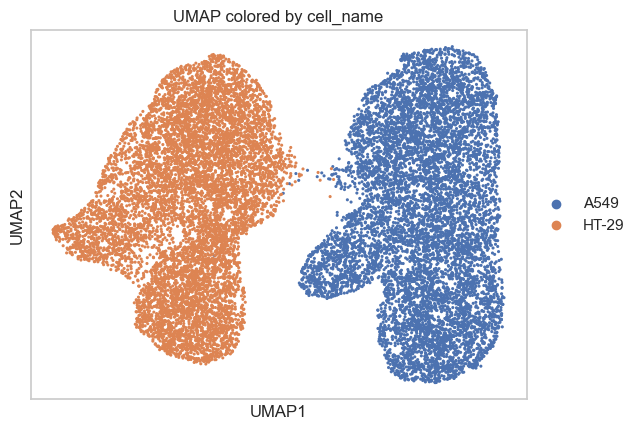

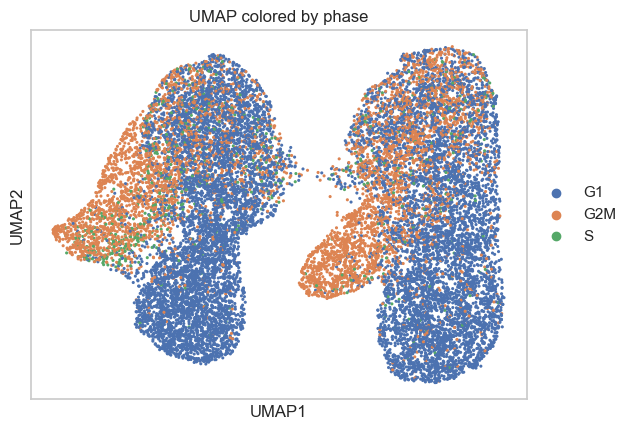

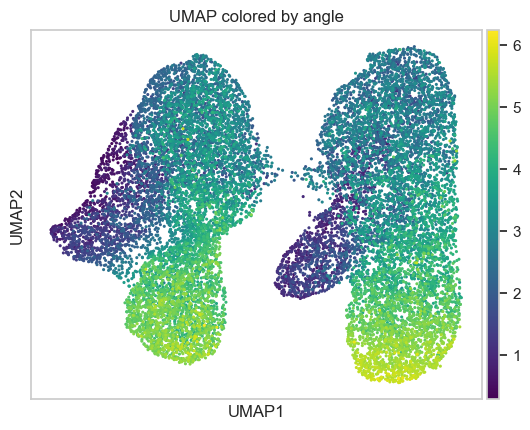

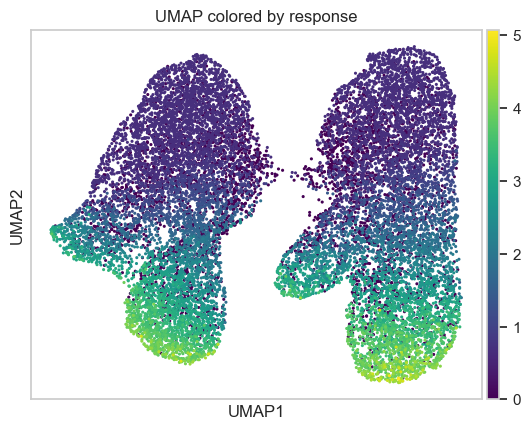

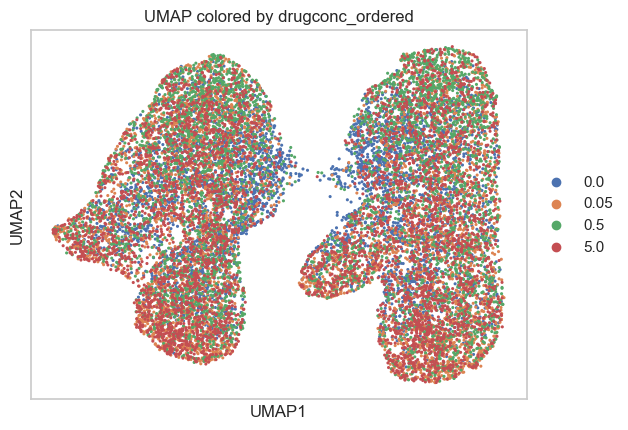

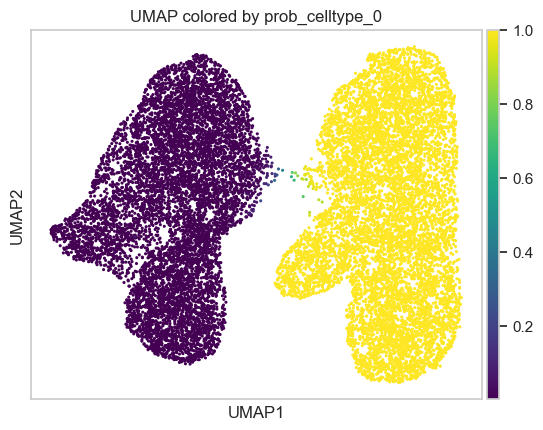

In [126]:

# Compute neighbors & UMAP on latent space
adata.obsm["X_latent"] = model.get_latent_representation(adata)
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.umap(adata)

# Set Seaborn style for nicer plots
sns.set(style="whitegrid")

# List of variables to plot
plot_vars = ["cell_name", "phase", "angle", "response", "drugconc_ordered","prob_celltype_0"]

# Plot UMAPs
for var in plot_vars:
    if var not in adata.obs.columns:
        print(f"Warning: {var} not found in adata.obs")
        continue

    sc.pl.umap(
        adata,
        color=var,
        size=20,
        cmap="viridis" if adata.obs[var].dtype.kind in "fiu" else None,
        title=f"UMAP colored by {var}",
        show=True
    )

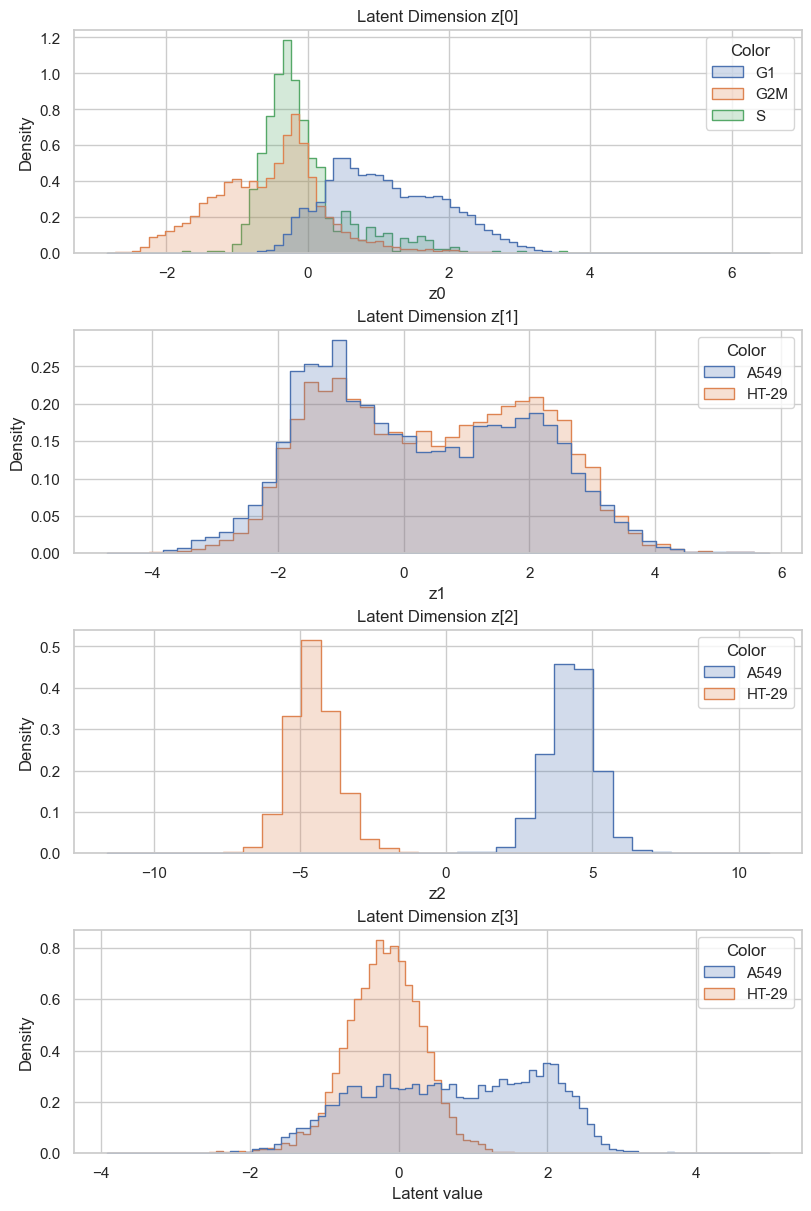

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get latent space
z = model.get_latent_representation()
n_latent = z.shape[1]

# Phase and Cell Line
phase = adata.obs["phase"]  # e.g. "G1", "S", "G2M"
cell_name = adata.obs["cell_name"]

# Plot
fig, axs = plt.subplots(n_latent, 1, figsize=(8, 3 * n_latent), constrained_layout=True)

for i in range(n_latent):
    df = pd.DataFrame({
        f"z{i}": z[:, i],
        "Color": phase if i == 0 else cell_name
    })
    sns.histplot(data=df, x=f"z{i}", hue="Color", ax=axs[i], element="step", stat="density", common_norm=False)
    axs[i].set_title(f"Latent Dimension z[{i}]")

axs[-1].set_xlabel("Latent value")
plt.show()


### Cell Cycle Function

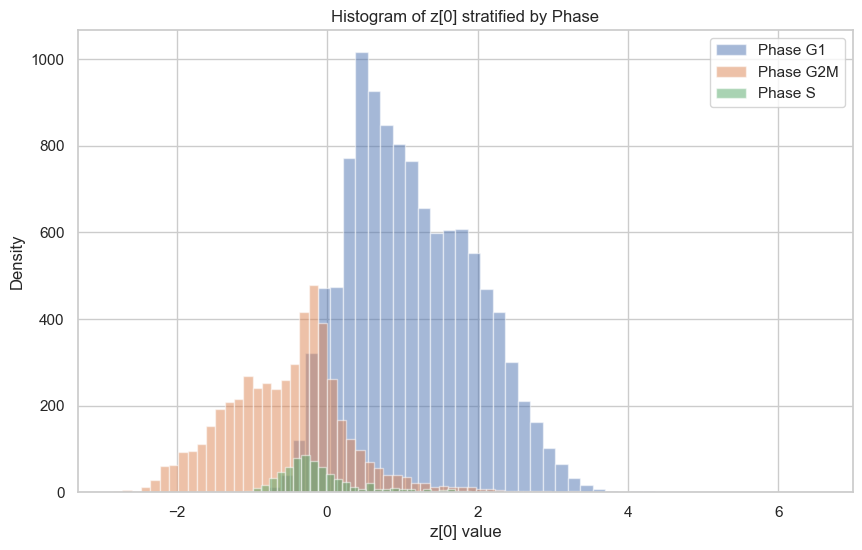

In [128]:
import numpy as np
import matplotlib.pyplot as plt


# Move z[:,0] to numpy
z0 = z[:, 0]

# Extract phase labels from adata
phase = adata.obs["phase"].to_numpy()

# Find unique phases (e.g., G1, S, G2M)
unique_phases = np.unique(phase)

# Plot
plt.figure(figsize=(10, 6))
for ph in unique_phases:
    mask = (phase == ph)
    plt.hist(z0[mask], bins=50, density=False, alpha=0.5, label=f'Phase {ph}')

plt.title("Histogram of z[0] stratified by Phase")
plt.xlabel("z[0] value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Move z[:,0] to numpy
z0 = z[:, 0].cpu().detach().numpy()

# Extract phase labels from adata
phase = adata.obs["phase"].to_numpy()

# Find unique phases (e.g., G1, S, G2M)
unique_phases = np.unique(phase)

# Prepare data for stacking
data_stacked = [z0[phase == ph] for ph in unique_phases]

# Plot stacked histogram
plt.figure(figsize=(10, 6))
plt.hist(data_stacked, bins=50, stacked=True, label=unique_phases)

plt.title("Stacked Histogram of z[0] by Cell Cycle Phase")
plt.xlabel("z[0] value")
plt.ylabel("Cell count")
plt.legend(title="Phase")
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

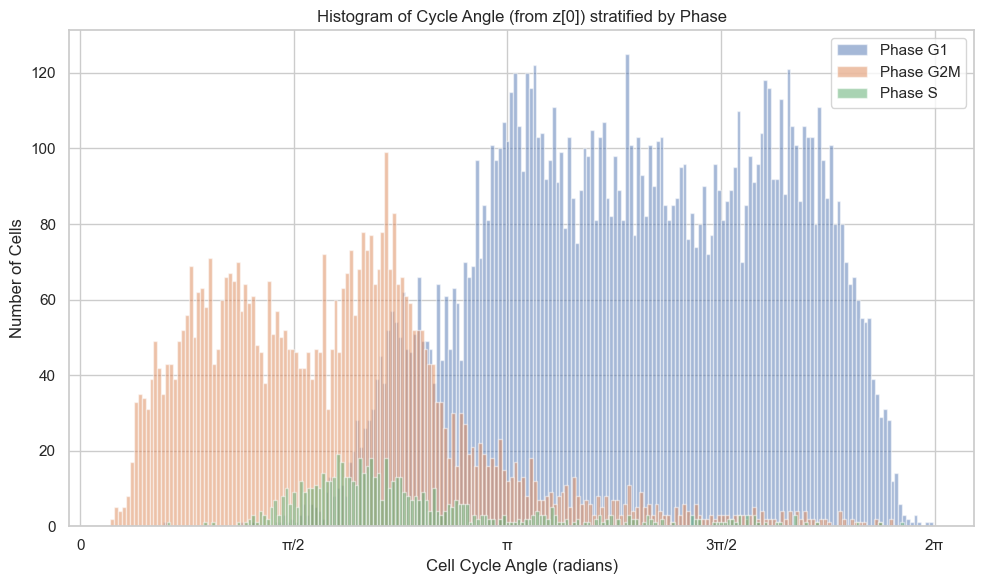

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Extract z0 and drug concentration
z0 = z[:, 0]
d_np = d.squeeze()

# Identify control cells
control_mask = d_np == 0
z0_control = z0[control_mask]

# --- Z-score normalization using control cells only ---
mu = z0_control.mean()
std = z0_control.std() + 1e-6  # Avoid division by zero
z0_norm = (z0 - mu) / std

# --- Apply sigmoid and rescale to [0, 2π] ---
z0_angle = 2 * np.pi * (1 / (1 + np.exp(-z0_norm)))  # sigmoid(z0_norm) * 2π

# Save back to adata.obs for plotting
adata.obs["angle"] = z0_angle

# --- Extract and plot by cell cycle phase ---
phase = adata.obs["phase"].to_numpy()
unique_phases = np.unique(phase)

plt.figure(figsize=(10, 6))
for ph in unique_phases:
    mask = (phase == ph)
    plt.hist(adata.obs["angle"][mask], bins=200, density=False, alpha=0.5, label=f'Phase {ph}')

plt.title("Histogram of Cycle Angle (from z[0]) stratified by Phase")
plt.xlabel("Cell Cycle Angle (radians)")
plt.ylabel("Number of Cells")
plt.xticks(
    [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
    ['0', 'π/2', 'π', '3π/2', '2π']
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


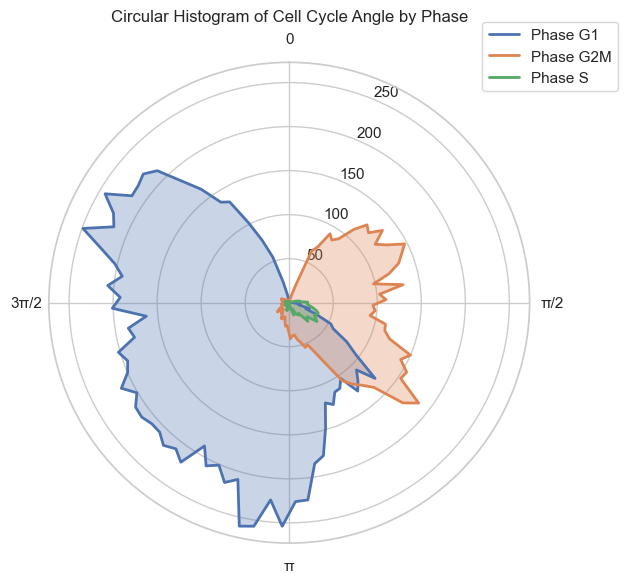

In [169]:
import numpy as np
import matplotlib.pyplot as plt

# Number of bins
n_bins = 100
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

# Extract angle and phase
angles = adata.obs["angle"].to_numpy()
phase = adata.obs["phase"].to_numpy()
unique_phases = np.unique(phase)

# Setup polar plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, polar=True)

# Plot histogram for each phase
for ph in unique_phases:
    mask = (phase == ph)
    hist, _ = np.histogram(angles[mask], bins=bin_edges)
    
    # Midpoints of bins for polar plot
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(bin_centers, hist, label=f'Phase {ph}', linewidth=2)
    ax.fill_between(bin_centers, hist, alpha=0.3)

# Polar plot styling
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2)
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', 'π/2', 'π', '3π/2'])
ax.set_title("Circular Histogram of Cell Cycle Angle by Phase", va='bottom')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


In [21]:
# --- Setup: Get gene index ---
gene_name = "TOP1"
gene_idx = np.where(adata.var_names == gene_name)[0][0]
print(f"Index of {gene_name}: {gene_idx}")

Index of TOP1: 14442


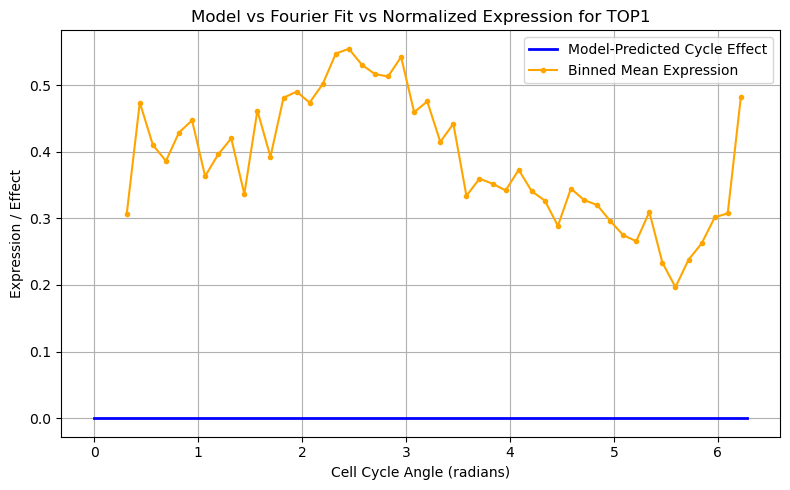

[0. 0. 0. 0. 0. 0. 0. 0.]
0.0


In [22]:
# --- Extract model-predicted Fourier weights and offset ---
W = model.module.decoder.fourier_W[:, gene_idx].detach().cpu().numpy()
offset = model.module.decoder.offset[0, gene_idx].detach().cpu().numpy()

# --- Prepare dense angle grid and compute model prediction ---
n_points = 500
angles = np.linspace(0, 2 * np.pi, n_points)[:, None]
n_fourier = W.shape[0] // 2

basis = np.concatenate(
    [fn(k * angles) for k in range(1, n_fourier + 1) for fn in (np.cos, np.sin)],
    axis=1
)
cycle_effect = basis @ W + offset

# --- Retrieve observed expression and cell angles ---
expr = adata[:, gene_idx].X.toarray().flatten() if not isinstance(adata.X, np.ndarray) else adata.X[:, gene_idx]
cell_angles = adata.obs["angle"].values

# --- Normalize expression (TPM-style) ---
raw_counts = adata.layers["counts"][:, gene_idx]
raw_counts = raw_counts.toarray().flatten() if not isinstance(raw_counts, np.ndarray) else raw_counts
library_size = adata.obs["tscp_count"].values
normalized_expr = raw_counts / library_size * 1e3

# --- Bin normalized expression by cell cycle angle ---
n_bins = 50
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
digitized = np.clip(np.digitize(cell_angles, bin_edges) - 1, 0, n_bins - 1)
mean_expr = np.array([
    normalized_expr[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
    for i in range(n_bins)
])

# --- Fit Fourier series to observed expression ---
X_fourier = np.stack(
    [fn(k * cell_angles) for k in range(1, n_fourier + 1) for fn in (np.cos, np.sin)],
    axis=1
)
coeffs, *_ = np.linalg.lstsq(X_fourier, normalized_expr, rcond=None)

X_dense = np.stack(
    [fn(k * angles.squeeze()) for k in range(1, n_fourier + 1) for fn in (np.cos, np.sin)],
    axis=1
)
fourier_fit_real = X_dense @ coeffs

# --- Plot predicted and observed signals ---
plt.figure(figsize=(8, 5))
plt.plot(angles.squeeze(), cycle_effect, label="Model-Predicted Cycle Effect", color="blue", lw=2)
plt.plot(bin_centers, mean_expr, 'o-', label="Binned Mean Expression", color="orange", markersize=3)
plt.title(f"Model vs Fourier Fit vs Normalized Expression for {gene_name}")
plt.xlabel("Cell Cycle Angle (radians)")
plt.ylabel("Expression / Effect")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(W)
print(offset)


# Observed vs Predicted Expression against Cell Cycle

In [13]:
likelihood_params = model.get_likelihood_parameters(adata=adata, give_mean=True)

In [14]:
d = adata.obs["drugconc"].values
is_treated = d > 0

train_idx = model.data_splitter.train_indices
val_idx = model.data_splitter.validation_indices
test_idx = model.data_splitter.test_indices

print("Treated in train:", is_treated[train_idx].sum())
print("Treated in val:", is_treated[val_idx].sum())
print("Treated in test:", is_treated[test_idx].sum())

AttributeError: 'CCVI' object has no attribute 'data_splitter'

## Filtered and Normalized

/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_7366/1889362264.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(cell_lines))


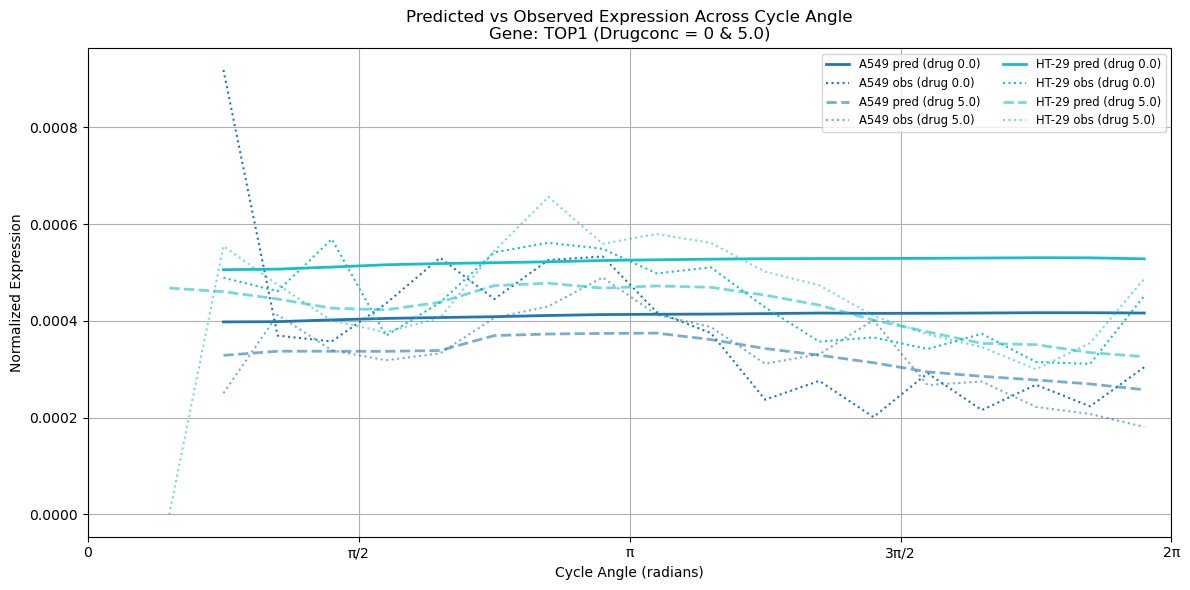

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --- Setup ---
n_bins = 20
bin_edges = np.linspace(0, 2*np.pi, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
cell_lines = adata.obs["cell_name"].unique()

raw_counts_full = adata.layers["counts"][:, gene_idx]
raw_counts_full = raw_counts_full.toarray().flatten() if not isinstance(raw_counts_full, np.ndarray) else raw_counts_full

# --- Colormap ---
cmap = cm.get_cmap("tab10", len(cell_lines))
color_map = {cell_line: cmap(i) for i, cell_line in enumerate(cell_lines)}

plt.figure(figsize=(12, 6))

for cell_line in cell_lines:
    color = color_map[cell_line]

    for drugconc, linestyle, alpha in [(0.0, '-', 1.0), (5.0, '--', 0.6)]:
        mask = (adata.obs["drugconc"] == drugconc) & (adata.obs["cell_name"] == cell_line)
        if mask.sum() == 0:
            continue

        angles = adata.obs["angle"].values[mask]
        library_size = adata.obs["tscp_count"].values[mask]

        predicted_expression = likelihood_params["mean"][mask, gene_idx] / library_size
        observed_expression = raw_counts_full[mask] / library_size

        digitized = np.clip(np.digitize(angles, bin_edges), 0, n_bins)
        mean_pred = np.array([
            predicted_expression[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])
        mean_obs = np.array([
            observed_expression[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
            for i in range(n_bins)
        ])

        label_pred = f"{cell_line} pred (drug {drugconc})"
        label_obs = f"{cell_line} obs (drug {drugconc})"

        plt.plot(bin_centers, mean_pred, color=color, linestyle=linestyle, lw=2, alpha=alpha, label=label_pred)
        plt.plot(bin_centers, mean_obs, color=color, linestyle=':', lw=1.5, alpha=alpha, label=label_obs)

# --- Final touches ---
# --- Final touches ---
plt.title(f"Predicted vs Observed Expression Across Cycle Angle\nGene: {gene_name} (Drugconc = 0 & 5.0)")
plt.xlabel("Cycle Angle (radians)")
plt.ylabel("Normalized Expression")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.xlim(0, 2 * np.pi)  # <-- this line ensures full 0–2π is shown
plt.grid(True)
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

## Normalized

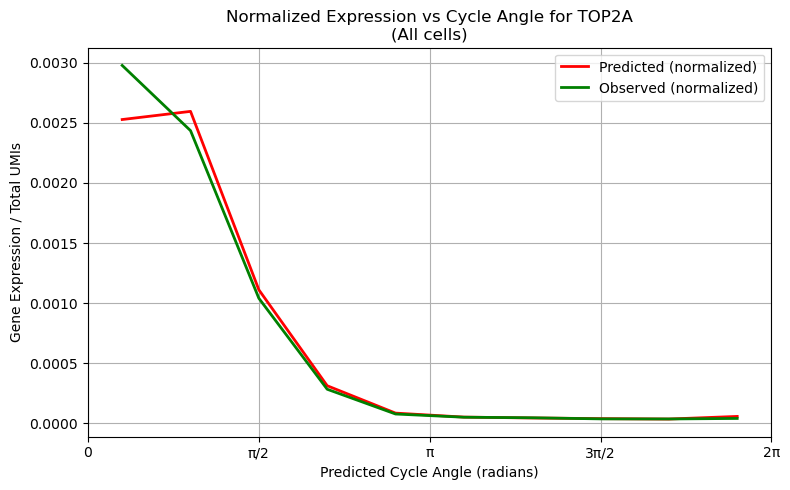

In [16]:
angles = adata.obs["angle"].values
library_size = adata.obs["tscp_count"].values  # or "n_counts"

# --- Predicted expression (normalized) ---
predicted_expression = likelihood_params["mean"][:, gene_idx] / library_size

# --- Observed expression (normalized) ---
raw_counts = adata.layers["counts"][:, gene_idx]
if not isinstance(raw_counts, np.ndarray):
    raw_counts = raw_counts.toarray().flatten()
observed_expression = raw_counts / library_size

# --- Binning ---
n_bins = 10
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
digitized = np.clip(np.digitize(angles, bin_edges) - 1, 0, n_bins - 1)

# --- Smoothed curves ---
mean_pred = np.array([
    predicted_expression[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
    for i in range(n_bins)
])
mean_obs = np.array([
    observed_expression[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
    for i in range(n_bins)
])


# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, mean_pred, color='red', lw=2, label='Predicted (normalized)')
plt.plot(bin_centers, mean_obs, color='green', lw=2, label='Observed (normalized)')
plt.title(f"Normalized Expression vs Cycle Angle for {gene_name}\n(All cells)")
plt.xlabel("Predicted Cycle Angle (radians)")
plt.ylabel("Gene Expression / Total UMIs")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## UMI over Cell Cycle

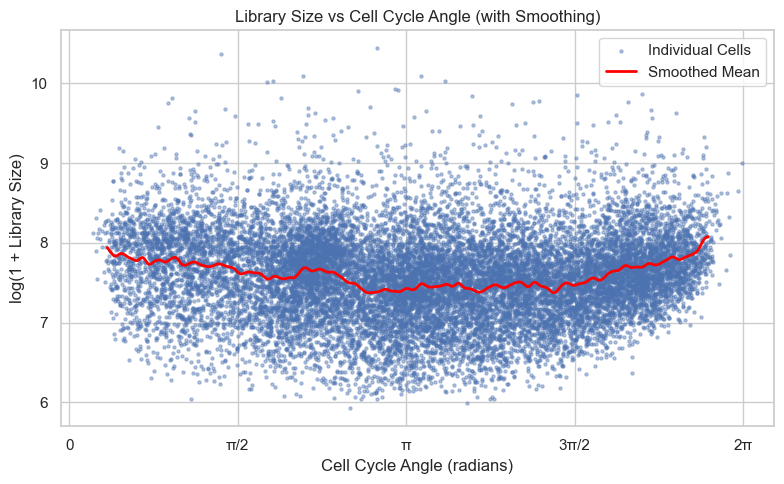

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# --- Extract data ---
library_size = np.log1p(adata.obs["tscp_count"].values)  # or "n_counts"
angle = adata.obs["angle"].values  # radians, 0 to 2π

# --- Scatterplot ---
plt.figure(figsize=(8, 5))
plt.scatter(angle, library_size, alpha=0.4, s=5, label="Individual Cells")

# --- Smoothing: bin the angles and smooth mean library size ---
n_bins = 400
bin_edges = np.linspace(0, 2*np.pi, n_bins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
digitized = np.digitize(angle, bin_edges) - 1
digitized = np.clip(digitized, 0, n_bins-1)

# Mean library size per bin
mean_library_size = np.array([
    library_size[digitized == i].mean() if (digitized == i).sum() > 0 else np.nan
    for i in range(n_bins)
])

# Smooth the mean with Gaussian filter
smoothed_library_size = gaussian_filter1d(mean_library_size, sigma=2)

# Plot smoothing line
plt.plot(bin_centers, smoothed_library_size, color='red', lw=2, label="Smoothed Mean")

# --- Final formatting ---
plt.title("Library Size vs Cell Cycle Angle (with Smoothing)")
plt.xlabel("Cell Cycle Angle (radians)")
plt.ylabel("log(1 + Library Size)")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [42]:
b_type = model.module.decoder.b_type.detach().cpu().numpy()  # shape: [n_cell_types, n_genes]
b0 = b_type[0]  # baseline for cell type 0
b1 = b_type[1]  # baseline for cell type 1
genes = adata.var_names.tolist()

In [43]:
state_dict = model.module.state_dict() 

In [44]:
state_dict.

SyntaxError: invalid syntax (1695842931.py, line 1)

In [116]:
W_drug = model.module.decoder.W_drug.detach().cpu().numpy()

In [118]:
# Step 1: Extract W_drug and flatten
W_drug = state_dict['decoder.W_drug'].cpu().detach().numpy().flatten()

# Step 2: Filter out Ensembl IDs
gene_names = adata.var.index.to_list()
non_ensembl_mask = ~pd.Series(gene_names).str.startswith("ENSG")
gene_names_filtered = pd.Series(gene_names)[non_ensembl_mask].to_list()
W_drug_filtered = W_drug[non_ensembl_mask.to_numpy()]

# Step 3: Create DataFrame and sort
W_drug_df = pd.DataFrame({"r1": W_drug_filtered}, index=gene_names_filtered)
W_drug_df_sorted = W_drug_df.sort_values(by="r1")

# Step 4: Save results
W_drug_df_sorted.head(400).index.to_series().to_csv("bottom_400_genes.txt", index=False, header=False)
W_drug_df_sorted.tail(400).index.to_series().to_csv("top_400_genes.txt", index=False, header=False)
W_drug_df_sorted.index.to_series().to_csv("background_genes.txt", index=False, header=False)

# Step 5: Top 400 by absolute weight
W_drug_abs_sorted = W_drug_df.reindex(np.abs(W_drug_df["r1"]).sort_values(ascending=False).index)
W_drug_abs_sorted.head(400).index.to_series().to_csv("top_400_abs_genes.txt", index=False, header=False)

print("✅ Also saved top_400_abs_genes.txt (by absolute weight)")


print("✅ Saved top_400_genes.txt, bottom_400_genes.txt, and background_genes.txt")


✅ Also saved top_400_abs_genes.txt (by absolute weight)
✅ Saved top_400_genes.txt, bottom_400_genes.txt, and background_genes.txt
